In [1]:
%reset -f

In [2]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# check the tensorflow and GPU
print(f"Using Tensorflow {tf.__version__}")
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(
    f"Found GPU adn CPU.\nTensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)


# import the datasets and check the files
import os

# path = "./phys591000-2023-final-project/"  # run on the local machine
# path = "/content/drive/Shareddrives/2023AI_final/2023AI_final/phys591000-2023-final-project/" # run on the google colab
path = "/kaggle/input/dune-neutrino/"  # Kaggle
if not os.path.isfile(path + "neutrino_test_data.npz") or os.path.isfile(
    path + "neutrino_train_data.npz"
):
    raise FileNotFoundError("test/train data was not found or is a directory")

# take out data from the datasets

data_train = np.load(path + "neutrino_training_data.npz")  # ideal data
data_test = np.load(path + "neutrino_test_data.npz")  # pseudo-exp data

name_train = data_train.files
name_test = data_test.files

(
    ve_train,
    vebar_train,
    vu_train,
    vubar_train,
    theta23_train,
    delta_train,
    ldm_train,
) = map(lambda n: data_train[n], name_train)
ve_test, vebar_test, vu_test, vubar_test = map(lambda n: data_test[n], name_test)


# create train and test data
X_train = np.stack((ve_train, vebar_train, vu_train, vubar_train), axis=-1)
Y_train = np.stack((theta23_train, delta_train, ldm_train), axis=-1)
# X_test = np.stack((ve_test, vebar_test, vu_test, vubar_test), axis=-1)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Using Tensorflow 2.12.0
Found GPU adn CPU.
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# [X] normalize training data to [0,1]
x_train_NH = X_train[ldm_train > 0]
print(f"Before normalized, the shape of x_train: {x_train_NH.shape}")
v_max = np.max(x_train_NH)
v_min = np.min(x_train_NH)
print(f"X-train normalized factors (v_max, v_min) = ({v_max}, {v_min})")
x_train_NH_norm = (x_train_NH - v_min) / (v_max - v_min)
print(f"After normalized, the shape of x_train: {x_train_NH_norm.shape}")

# [Y] normalize training label to [0,1] --> using sine function 
y_train_NH = Y_train[:, 1][ldm_train > 0]
print(f"Before normalized, the shape of y_train: {y_train_NH.shape}")
# v_max = np.max(y_train_NH)
# v_min = np.min(y_train_NH)
y_train_NH_norm = np.pi * (y_train_NH-180)/180 # degree -> rad
# y_train_NH_norm = np.sin(y_train_NH * np.pi/180) # degree -> rad
# print(f"Y-train normalized factors (v_max, v_min) = ({v_max}, {v_min})")
print(f"After normalized, the shape of y_train: {y_train_NH_norm.shape}")

# clear unused variables
del (
    X_train,
    Y_train,
    ve_train,
    vebar_train,
    vu_train,
    vubar_train,
    theta23_train,
    delta_train,
    ldm_train,
    ve_test,
    vebar_test,
    vu_test,
    vubar_test,
)
gc.collect()

Before normalized, the shape of x_train: (500027, 65, 4)
X-train normalized factors (v_max, v_min) = (1919.03, 2.74423)
After normalized, the shape of x_train: (500027, 65, 4)
Before normalized, the shape of y_train: (500027,)
After normalized, the shape of y_train: (500027,)


121

In [4]:
reg_model = tf.keras.models.load_model("/kaggle/input/regression/mod_vgg.h5")
x_pred = reg_model.predict(x_train_NH_norm)

15626/15626 [==============================] - 37s 2ms/step


In [5]:
from numba import njit

# @njit(parallel=True, fastmath=True)
def kernel(array, target):
    '''
    * theta1 is within [-pi/2, pi/2]; theta2 is out
      the previous range, but within [-pi, pi].
    * label(0) means the differences between predicted
      result and the truth label is within the inner 
      range; the other label(1) refer to the outer range.
    '''
    
    min_value = np.min(array)
    max_value = np.max(array)
    normalized_array = (array - min_value) * 2 / (max_value - min_value) - 1
#     print(np.min(normalized_array), np.max(normalized_array))
    
    label = np.empty(len(normalized_array))
    theta1 = np.empty(len(normalized_array))
    theta2 = np.empty(len(normalized_array))
    for ind, (i, j) in enumerate(zip(normalized_array, target)):
        theta = np.arcsin(i)
        if theta >= 0:
            theta1[ind], theta2[ind] = theta, np.pi - theta
        else:
            theta1[ind], theta2[ind] = theta, -np.pi - theta 
        if np.abs(j + theta1[ind]) <= np.abs(j + theta2[ind]):
            label[ind] = 0
        else:
            label[ind] = 1
    return label, theta1, theta2

label, theta1, theta2 = kernel(x_pred[:,0], y_train_NH_norm)

In [6]:
# print(theta1[6:10])
# print(theta2[6:10])
# print(y_train_NH_norm[6:10])
# print(np.abs(theta1[6:10] - y_train_NH_norm[6:10]))
# print(np.abs(theta2[6:10] - y_train_NH_norm[6:10]))
# print(label[6:10])

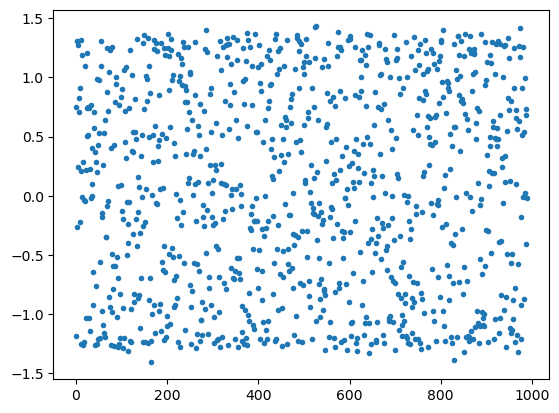

In [7]:
plt.plot(theta1[10:1000], '.')

In [8]:
from sklearn.model_selection import train_test_split

# split the training dataset into training and validation, with test_size = 0.2
tf.random.set_seed(2023)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_NH_norm,
    label,
    test_size=0.2,
    shuffle=True,
)

# clear unused variables
# del x_train_NH_norm, y_train_NH_norm
# gc.collect()

(array([251684.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 248343.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

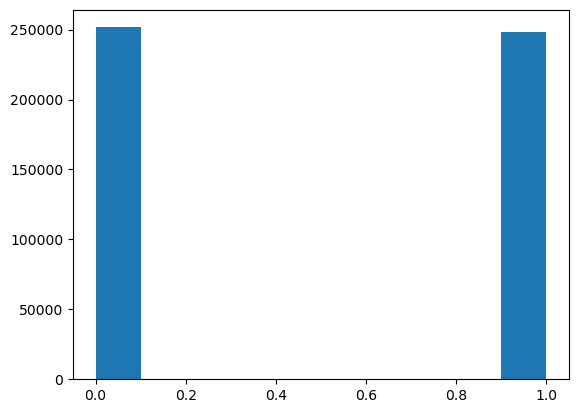

In [9]:
plt.hist(label)

In [10]:
from tensorflow.keras import Input, Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    MaxPooling2D,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
)

def create_model_vgg_mod(input_dim):
    def conv2(inputs, filters, kernel_size):
        x = Conv2D(filters, kernel_size=kernel_size, strides=2, padding="same", activation="relu")(inputs)
        x = Conv2D(filters, kernel_size=kernel_size, strides=2, padding="same", activation="relu")(x)
        x = MaxPooling2D(padding="same")(x)
        return x

    inputs = Input(shape=input_dim)
    x = conv2(inputs, filters=32, kernel_size=(2,2))
    x =Dropout(0.2)(x)
    x = conv2(inputs, filters=64, kernel_size=(2,2))
    x = Flatten()(x)
    x =Dropout(0.2)(x)
    x = Dense(128, kernel_regularizer=regularizers.l2(0.005), activation="relu")(x)
    x =Dropout(0.2)(x)
    x = Dense(64, kernel_regularizer=regularizers.l2(0.005), activation="relu")(x)
    x =Dropout(0.2)(x)
    x = Dense(1, kernel_regularizer=regularizers.l2(0.005), activation="sigmoid")(x)
    VGG_mod = Model(inputs, x, name="vgg")
    VGG_mod.summary()

    model_inputs = Input(shape=input_dim)
    model_outputs = VGG_mod(model_inputs)
    vgg_mod = Model(inputs=model_inputs, outputs=model_outputs)
    return vgg_mod


from tensorflow.keras.optimizers import Adam

# Declare the model
vgg = create_model_vgg_mod(
    input_dim=(x_train.shape[1], x_train.shape[2], 1)
)

# Compile the model
vgg.compile(optimizer=Adam(5e-6), loss="binary_crossentropy", metrics=['binary_accuracy'])

Model: "vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65, 4, 1)]        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 2, 64)         320       
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 1, 64)         16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dropout_1 (Dropout)         (None, 576)               0         
                                                               

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# train
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=30,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

vgg.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=256,
    batch_size=128,
    callbacks=[early_stopping],
    shuffle=True,
    verbose=2,
)

# save model
vgg.save("/kaggle/working/classification_cp_phase.h5")

Epoch 1/256
3126/3126 - 18s - loss: 1.9034 - binary_accuracy: 0.5094 - val_loss: 1.6552 - val_binary_accuracy: 0.5022 - 18s/epoch - 6ms/step
Epoch 2/256
3126/3126 - 14s - loss: 1.4608 - binary_accuracy: 0.5225 - val_loss: 1.2884 - val_binary_accuracy: 0.5022 - 14s/epoch - 4ms/step
Epoch 3/256
3126/3126 - 14s - loss: 1.1560 - binary_accuracy: 0.5296 - val_loss: 1.0408 - val_binary_accuracy: 0.5022 - 14s/epoch - 4ms/step
Epoch 4/256
3126/3126 - 13s - loss: 0.9566 - binary_accuracy: 0.5285 - val_loss: 0.8856 - val_binary_accuracy: 0.5022 - 13s/epoch - 4ms/step
Epoch 5/256
3126/3126 - 14s - loss: 0.8369 - binary_accuracy: 0.5215 - val_loss: 0.7973 - val_binary_accuracy: 0.5022 - 14s/epoch - 5ms/step
Epoch 6/256
3126/3126 - 14s - loss: 0.7717 - binary_accuracy: 0.5267 - val_loss: 0.7513 - val_binary_accuracy: 0.5022 - 14s/epoch - 4ms/step
Epoch 7/256
3126/3126 - 14s - loss: 0.7378 - binary_accuracy: 0.5519 - val_loss: 0.7264 - val_binary_accuracy: 0.6693 - 14s/epoch - 5ms/step
Epoch 8/256
3

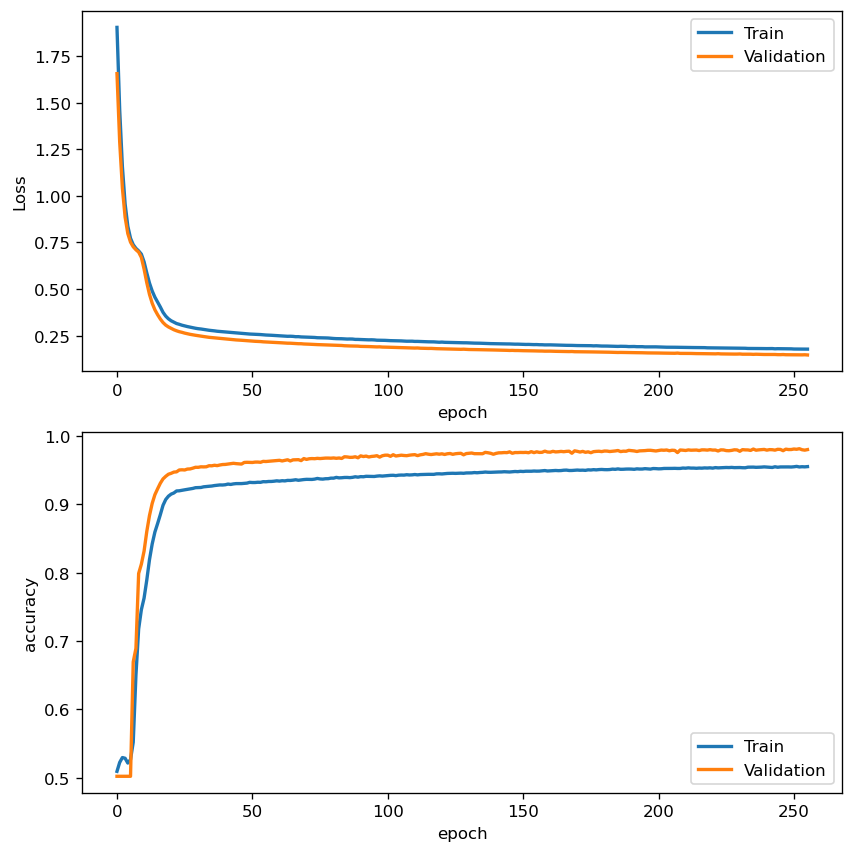

3126/3126 [==============================] - 5s 2ms/step


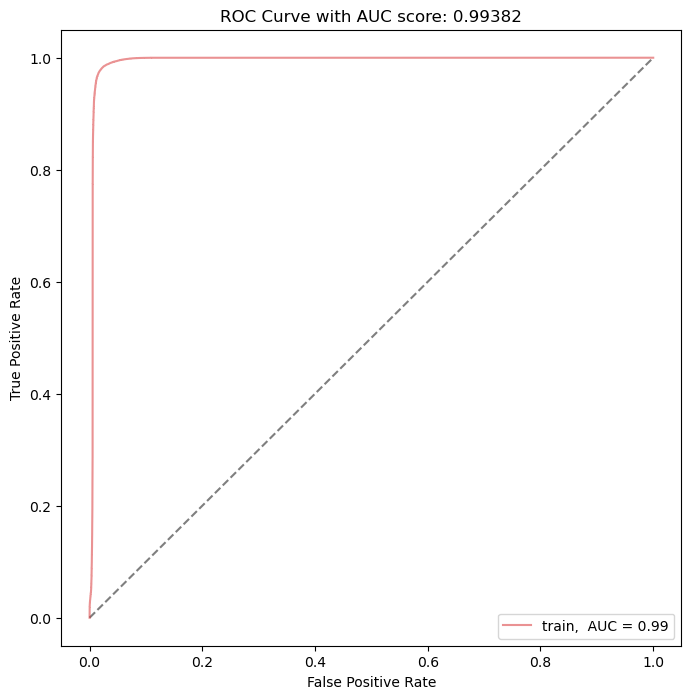

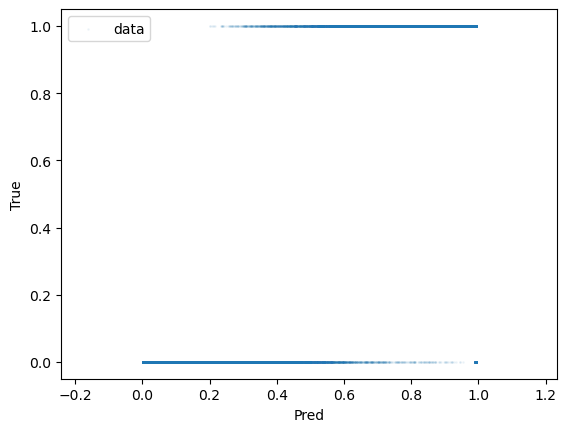

In [12]:
# check the loss function

# training plots
fig = plt.figure(figsize=(7, 7), dpi=120, constrained_layout=True)
rec = vgg.history
plt.subplot(2,1,1)
plt.plot(rec.history['loss'], lw=2, label='Train')
plt.plot(rec.history['val_loss'], lw=2, label='Validation')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(rec.history['binary_accuracy'], lw=2, label='Train')
plt.plot(rec.history['val_binary_accuracy'], lw=2, label='Validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# ROC curve and AUC score
from sklearn.metrics import roc_curve, auc

x_val_pred = vgg.predict(x_val)
plt.figure(figsize=(8,8), dpi=100)
plt.plot([0, 1], [0, 1],linestyle='--', c='tab:grey')
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, x_val_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, alpha=.5, c='tab:red', label = f'train,  AUC = {roc_auc.round(2)}')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'ROC Curve with AUC score: {roc_auc.round(5)}')
plt.show()

# test predictions with scatter plot
plt.scatter(x_val_pred, y_val, s=1, alpha=0.05, label="data")
plt.legend(loc="best")
plt.xlabel("Pred")
plt.ylabel("True")
plt.axis('equal')
plt.show()